In [48]:
WORKER_COUNT = 8

In [49]:
# Sync models
# gsutil -m rsync -r /mnt/seals/models/ gs://thesis-penguins/models/ 
# aws s3 sync /mnt/seals/models s3://thesisvids/penguins/models/

In [50]:
# whether to log each feature and sequence status
verbose = True

In [51]:
import gc
import os
import pandas as pd
pd.options.display.max_rows = 5000
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
import itertools
import sys
sys.path.append('..')

In [52]:
# setup paths
pwd = os.getcwd().replace("notebooks","")
path_cache = pwd + 'cache/'
path_data = pwd + 'data/'

In [53]:
# setup logging
# any explicit log messages or uncaught errors to stdout and file /logs.log
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(pwd, "logs")),
        logging.StreamHandler()
    ])
# init logger
logger = logging.getLogger()
# make logger aware of any uncaught exceptions
def handle_exception(exc_type, exc_value, exc_traceback):
    if issubclass(exc_type, KeyboardInterrupt):
        sys.__excepthook__(exc_type, exc_value, exc_traceback)
        return

    logger.error("Uncaught exception", exc_info=(exc_type, exc_value, exc_traceback))
sys.excepthook = handle_exception

In [54]:
from deepvideoclassification.pretrained_CNNs import pretrained_model_names, pretrained_model_names_bucketed

# Helper functions

In [91]:
def get_results():
    """
    Load the results of all completed models into a dataframe and return sorted on val_acc
    """
    
    path_models = pwd + 'models/'

    results = []

    for folder, subs, files in os.walk(path_models):
        for filename in files:
            if 'results.json' in filename:
                with open(os.path.abspath(os.path.join(folder, filename))) as f:
                    data = json.load(f)
                results.append(data)

    results = pd.DataFrame(results)        
    results.sort_values("fit_val_acc", inplace=True, ascending=False)
    return results

In [123]:
def remove_completed_experiments(experiments):
    """
    Helper function to remove the completed experiments from experiments dataframe
    """
    
    # get updated result set
    results = get_results()
    
    # merge results onto experiments
    experiments = pd.merge(experiments, results[['model_id','fit_val_acc']], left_on='model_id', right_on='model_id', how='left')
    experiments['done'] = (experiments['fit_val_acc']>0).astype(int)
    print("{}/{} experiments done".format(experiments[experiments['done'] == 1].shape[0], len(experiments)))
    
    # only keep experiments not done
    experiments = experiments[experiments['done'] == 0]

    # clean up
    del experiments['done']
    del experiments['fit_val_acc']
    
    # return experiments already done
    return experiments

In [263]:
def reassign_workers(experiments):
    """
    Helper function to reassign outstanding experiments to workers
    """
    
    
    # get updated result set
    results = get_results()
    
    # merge results onto experiments
    experiments = pd.merge(experiments, results[['model_id','fit_val_acc']], left_on='model_id', right_on='model_id', how='left')
    experiments['done'] = (experiments['fit_val_acc']>0).astype(int)
    
    # reassign workers
    global todo_idx
    todo_idx = 0
    
    def assign_not_done_to_worker(row):
        """ helper lambda"""
        global todo_idx
        if row['done'] == 0:
            todo_idx+=1
            return todo_idx % WORKER_COUNT
        else:
            return 0
    
    experiments['WORKER'] = experiments.apply(assign_not_done_to_worker, axis=1)
    
    # clean up
    del experiments['done']
    del experiments['fit_val_acc']
    
    return experiments

# Create list of experiments to be run

* batch 1 = run frozen image MLP, LRCNNs and concat models on 1 of each pretrained_model_name in buckets (bucketed on feature sizes and limited to max sequence_length of 10)

* batch 2 = for best configurations from batch 1, run other pretrained models in buckets and run longer sequence lengths, maybe try different convolution kernel sizes

* batch 3 = run trainable MLP and LRCNN on best performing frozen variants

* batch 4 = run trainable but initializing with best CNN weights

* batch 5 = run C3D models

* batch 6 = analyze effect of dropout and pooling with best model

# Batch 1

In [206]:
experiment_batch_name = 'experiment_batch_1'

In [207]:
# init model id - need to make sure we pick up where we leave off don't overwrite it between batches
model_id_start = 0

In [208]:
# init list of experiments
experiments = []

In [209]:
pooling = 'max'
layer_sizes = [512, 256, 128, 0]
dropouts = [0.2]
sequence_lengths = [3,5,10]
sequence_models = ["LSTM", "SimpleRNN", "GRU", "Convolution1D"]
sequence_model_layer_counts = [1,2]

In [210]:
####################
### image_MLP_frozen 
####################

for pretrained_model_name in pretrained_model_names_bucketed:
    for layer_1_size in layer_sizes:
        for layer_2_size in layer_sizes:
            for layer_3_size in layer_sizes:
                for dropout in dropouts:

                    # build experiment parameters
                    experiment = {}
                    
                    experiment['architecture'] = 'image_MLP_frozen'
                    experiment['sequence_length'] = 1
                    experiment['pretrained_model_name'] = pretrained_model_name
                    experiment['layer_1_size'] = layer_1_size
                    experiment['layer_2_size'] = layer_2_size
                    experiment['layer_3_size'] = layer_3_size
                    experiment['dropout'] = dropout
                    experiment['pooling'] = 'max' # outperforms avg across all parameters
                    
                    # add to list of experiments
                    experiments.append(experiment)

In [211]:
####################
### video_MLP_concat
####################

for sequence_length in sequence_lengths:
    for pretrained_model_name in pretrained_model_names_bucketed:
        for layer_1_size in layer_sizes:
            for layer_2_size in layer_sizes:
                for layer_3_size in layer_sizes:
                    for dropout in dropouts:

                        # build experiment parameters
                        experiment = {}

                        experiment['architecture'] = 'video_MLP_concat'
                        experiment['pretrained_model_name'] = pretrained_model_name
                        experiment['layer_1_size'] = layer_1_size
                        experiment['layer_2_size'] = layer_2_size
                        experiment['layer_3_size'] = layer_3_size
                        experiment['dropout'] = dropout
                        experiment['pooling'] = 'max' # outperforms avg across all parameters
                        experiment['sequence_length'] = sequence_length

                        # add to list of experiments
                        experiments.append(experiment)

In [212]:
######################
### video_LRCNN_frozen
######################

for sequence_length in sequence_lengths:
    for pretrained_model_name in pretrained_model_names_bucketed:
        for layer_1_size in layer_sizes:
            for layer_2_size in layer_sizes:
                for layer_3_size in layer_sizes:
                    for dropout in dropouts:
                        for sequence_model in sequence_models:
                            for sequence_model_layers in sequence_model_layer_counts:

                                # build experiment parameters
                                experiment = {}

                                experiment['architecture'] = 'video_LRCNN_frozen'
                                experiment['pretrained_model_name'] = pretrained_model_name
                                experiment['layer_1_size'] = layer_1_size
                                experiment['layer_2_size'] = layer_2_size
                                experiment['layer_3_size'] = layer_3_size
                                experiment['dropout'] = dropout
                                experiment['pooling'] = 'max' # outperforms avg across all parameters
                                experiment['sequence_model'] = sequence_model
                                experiment['sequence_model_layers'] = sequence_model_layers
                                experiment['sequence_length'] = sequence_length

                                # add to list of experiments
                                experiments.append(experiment)

In [213]:
########################
### convert to dataframe
########################

experiments = pd.DataFrame(experiments)

### create model id column for this experiment batch
model_id_list = list(range(0,len(experiments)))
experiments['model_id'] = model_id_list

# assign to workers
experiments['WORKER'] = experiments['model_id'].apply(lambda x: x % WORKER_COUNT)

In [214]:
experiments.shape

(5376, 12)

In [215]:
############################################
### remove invalid experiment configurations
############################################

# Just won't run experiments for those model_ids - not an error that model ids not congituous count from 0!

# delete video experiments with 0 neurons in a layer with nonzero neurons in later layers
experiments = experiments[~((experiments['layer_1_size'] == 0) & (experiments['layer_2_size'] > 0))]
experiments = experiments[~((experiments['layer_1_size'] == 0) & (experiments['layer_3_size'] > 0))]
experiments = experiments[~((experiments['layer_2_size'] == 0) & (experiments['layer_3_size'] > 0))]

# delete video experiments where convolution_kernel_size > sequence_length (convolution_kernel_size defaults to 3 and not set in this batch)
experiments = experiments[~((experiments['sequence_model'] == 'Convolution1D') & (experiments['sequence_length']<=3))]

In [216]:
# delete LRCNN_frozen experiments with layer_1_size == 0
experiments = experiments[~((experiments['architecture'] == 'video_LRCNN_frozen') & (experiments['layer_1_size']==0))]

In [217]:
##################################
### output experiment batch to CSV
##################################
print(experiment_batch_name)
experiments.to_csv(pwd + "experiments/" + experiment_batch_name + '.csv', index=False)

experiment_batch_1


In [218]:
print(experiments.shape)
experiments.tail().T

(3054, 12)


,5243,5244,5245,5246,5247
architecture,video_LRCNN_frozen,video_LRCNN_frozen,video_LRCNN_frozen,video_LRCNN_frozen,video_LRCNN_frozen
dropout,0.2,0.2,0.2,0.2,0.2
layer_1_size,128,128,128,128,128
layer_2_size,0,0,0,0,0
layer_3_size,0,0,0,0,0
pooling,max,max,max,max,max
pretrained_model_name,resnet50,resnet50,resnet50,resnet50,resnet50
sequence_length,10,10,10,10,10
sequence_model,SimpleRNN,GRU,GRU,Convolution1D,Convolution1D
sequence_model_layers,2,1,2,1,2


In [219]:
# # upload to s3
# response = os.system("aws s3 cp " + pwd + "experiments/" + experiment_batch_name + '.csv s3://thesisvids/penguins/' + experiment_batch_name + '.csv')
# if response == 0:
#     print("upload success")
# else:
#     print("upload error")

In [220]:
# # # upload to GCP
# response = os.system("gsutil cp " + pwd + "experiments/" + experiment_batch_name + '.csv gs://thesis-penguins/' + experiment_batch_name + '.csv')
# if response == 0:
#     print("upload success")
# else:
#     print("upload error")

# Batch 2

In [222]:
# reload experiments
experiments = pd.read_csv(pwd + "experiments/experiment_batch_1.csv")
experiments.shape

(3054, 12)

In [223]:
# define experiment batch name
experiment_batch_name = 'experiment_batch_2'

In [224]:
# init model id - need to make sure we pick up where we leave off don't overwrite it between batches
model_id_start = pd.read_csv(pwd + "experiments/experiment_batch_1.csv")['model_id'].max() + 1
# read list of paths and find max there too to be double safe we don't overwrite model_ids
paths = os.listdir(path_models)
paths = [int(p) for p in paths]
model_id_start = max(model_id_start,max(paths) + 1)
print(model_id_start)

5248


In [229]:
# remove experiments already completed
experiments = remove_completed_experiments(experiments)
experiments.shape

0/104 experiments done


(104, 12)

In [230]:
# get top 20 results from previous batch
results = get_results()

In [231]:
# we'll create experiments with same parameters as best 20 so far but now with longer sequence lengths
results_top20 = results[['architecture','layer_1_size','layer_2_size', 'layer_3_size','dropout','pretrained_model_name','pooling','sequence_length','sequence_model','sequence_model_layers']].head(20)
sequence_lengths = [15, 20]

In [232]:
# init list for extra experiments to append to outstanding experiments
experiments_next = []

# init model_id
model_id = model_id_start

for sequence_length in sequence_lengths:
    for result in results_top20.values:
        
        # convert result params to dict to create experiment from
        result_dict = dict(zip(results_top20.columns, result))

        experiment = {}                    
        experiment['architecture'] = 'video_lrcnn_frozen'
        experiment['sequence_model'] = result_dict['sequence_model']
        experiment['sequence_model_layers'] = result_dict['sequence_model_layers']
        experiment['sequence_length'] = sequence_length
        experiment['pretrained_model_name'] = result_dict['pretrained_model_name']
        experiment['layer_1_size'] = result_dict['layer_1_size']
        experiment['layer_2_size'] = result_dict['layer_2_size']
        experiment['layer_3_size'] = result_dict['layer_3_size']
        experiment['dropout'] = result_dict['dropout']
        experiment['pooling'] = 'max' # always outperforms avg
        
        experiment['model_id'] = model_id
        
        # assign to worker
        experiment['WORKER'] = model_id % WORKER_COUNT

        # increment unique model id
        model_id +=1
        
        # add to list of additional experiments
        experiments_next.append(experiment)

In [233]:
# convert to dataframe
experiments_next = pd.DataFrame(experiments_next)
experiments_next.shape

In [235]:
# merge new experiments onto outstanding experiments
experiments = pd.concat([experiments, experiments_next], axis = 0)
experiments.shape

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(144, 12)

In [236]:
experiments.tail(100)

,WORKER,architecture,dropout,layer_1_size,layer_2_size,layer_3_size,model_id,pooling,pretrained_model_name,sequence_length,sequence_model,sequence_model_layers
44,0,video_LRCNN_frozen,0.2,128,512,512,5120,max,resnet50,10,LSTM,1.0
45,1,video_LRCNN_frozen,0.2,128,512,512,5121,max,resnet50,10,LSTM,2.0
46,3,video_LRCNN_frozen,0.2,128,512,512,5123,max,resnet50,10,SimpleRNN,2.0
47,4,video_LRCNN_frozen,0.2,128,512,512,5124,max,resnet50,10,GRU,1.0
48,5,video_LRCNN_frozen,0.2,128,512,512,5125,max,resnet50,10,GRU,2.0
49,0,video_LRCNN_frozen,0.2,128,512,256,5128,max,resnet50,10,LSTM,1.0
50,1,video_LRCNN_frozen,0.2,128,512,256,5129,max,resnet50,10,LSTM,2.0
51,4,video_LRCNN_frozen,0.2,128,512,256,5132,max,resnet50,10,GRU,1.0
52,5,video_LRCNN_frozen,0.2,128,512,256,5133,max,resnet50,10,GRU,2.0
53,0,video_LRCNN_frozen,0.2,128,512,128,5136,max,resnet50,10,LSTM,1.0


In [267]:
experiments['WORKER'].value_counts()

7    18
6    18
5    18
4    18
3    18
2    18
1    18
0    18
Name: WORKER, dtype: int64

In [268]:
experiments = reassign_workers(experiments)

In [269]:
experiments['WORKER'].value_counts()

7    18
6    18
5    18
4    18
3    18
2    18
1    18
0    18
Name: WORKER, dtype: int64

In [271]:
##################################
### output experiment batch to CSV
##################################
print(experiment_batch_name)
experiments.to_csv(pwd + "experiments/" + experiment_batch_name + '.csv', index=False)

experiment_batch_2


In [137]:
# # upload to s3
# response = os.system("aws s3 cp " + pwd + "experiments/" + experiment_batch_name + '.csv s3://thesisvids/penguins/' + experiment_batch_name + '.csv')
# if response == 0:
#     print("upload success")
# else:
#     print("upload error")

In [272]:
# # upload to GCP
response = os.system("gsutil cp " + pwd + "experiments/" + experiment_batch_name + '.csv gs://thesis-penguins/' + experiment_batch_name + '.csv')
if response == 0:
    print("upload success")
else:
    print("upload error")

upload success


# Batch 3

In [ ]:
# run trainable MLP and LRCNN on best performing frozen variants

In [ ]:
#######################
### image_MLP_trainable
#######################

architecture = 'video_LRCNN_trainable'

In [ ]:
#########################
### video_LRCNN_trainable
#########################

architecture = 'video_LRCNN_trainable'

# Batch 4

In [ ]:
# run trainable but initializing with best CNN weights

# Batch 5

# Analyze results from batch 1

## load results.json for all models into dataframe

In [92]:
results = get_results()

In [71]:
results.head(20).T

,1072,188,1888,2710,2657,2604,2956,2739,3143,266,288,3129,3205,3009,21,1989,434,2991,553,1117
architecture,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen
batch_size,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
data_total_rows_test,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130,3130
data_total_rows_train,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399,60399
data_total_rows_valid,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398,6398
dropout,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
fit_best_round,2,3,3,3,3,3,2,2,2,3,1,2,2,2,2,2,2,3,2,1
fit_dt_test_duration_seconds,15,31,26,12,27,15,28,13,23,31,16,26,12,14,17,16,18,25,15,10
fit_dt_test_end,2019-01-24 07:02:41,2019-01-23 03:34:38,2019-01-22 22:58:13,2019-01-24 03:25:23,2019-01-23 00:18:48,2019-01-24 08:58:42,2019-01-23 02:47:19,2019-01-24 04:40:24,2019-01-22 20:03:14,2019-01-23 02:54:16,2019-01-24 08:16:05,2019-01-22 22:31:36,2019-01-24 04:15:48,2019-01-24 06:08:33,2019-01-24 11:12:10,2019-01-24 08:23:52,2019-01-24 11:52:30,2019-01-22 22:22:13,2019-01-24 09:04:38,2019-01-24 00:57:23


> top 20 models all `video_lrcnn_frozen` with `vgg16` and `LSTM`, `SimpleRNN`, `GRU` sequence models and sequence_length = 10 ... we'll re-run these with sequence length = 15 and 20 for batch 2

In [57]:
# results[results['model_id'].isin([362, 550, 162, 133, 3115, 3125])].T

## results per architecture

In [58]:
results[results['architecture'] == 'video_mlp_concat'].head(5).T

,1074,1192,1701,2883,3131
architecture,video_mlp_concat,video_mlp_concat,video_mlp_concat,video_mlp_concat,video_mlp_concat
batch_size,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3
data_total_rows_test,3137,3135,3137,3137,3137
data_total_rows_train,60553,60509,60553,60553,60553
data_total_rows_valid,6412,6408,6412,6412,6412
dropout,0.2,0.2,0.2,0.2,0.2
fit_best_round,3,3,2,1,2
fit_dt_test_duration_seconds,1,0,1,0,0
fit_dt_test_end,2019-01-20 21:15:03,2019-01-20 23:33:37,2019-01-20 21:37:34,2019-01-20 20:46:20,2019-01-20 21:17:15


In [59]:
results[results['architecture'] == 'image_mlp_frozen'].head(5).T

,2453,2419,1196,2933,2205
architecture,image_mlp_frozen,image_mlp_frozen,image_mlp_frozen,image_mlp_frozen,image_mlp_frozen
batch_size,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3
data_total_rows_test,3139,3139,3139,3139,3139
data_total_rows_train,60597,60597,60597,60597,60597
data_total_rows_valid,6416,6416,6416,6416,6416
dropout,0.2,0.2,0.2,0.2,0.2
fit_best_round,2,2,2,3,2
fit_dt_test_duration_seconds,2,1,1,1,1
fit_dt_test_end,2019-01-20 14:25:08,2019-01-20 14:01:02,2019-01-20 14:07:05,2019-01-20 13:54:52,2019-01-20 14:13:38


In [60]:
results[results['architecture'] == 'video_lrcnn_frozen'].head(5).T

,1072,188,1888,2710,2657
architecture,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen
batch_size,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3
data_total_rows_test,3130,3130,3130,3130,3130
data_total_rows_train,60399,60399,60399,60399,60399
data_total_rows_valid,6398,6398,6398,6398,6398
dropout,0.2,0.2,0.2,0.2,0.2
fit_best_round,2,3,3,3,3
fit_dt_test_duration_seconds,15,31,26,12,27
fit_dt_test_end,2019-01-24 07:02:41,2019-01-23 03:34:38,2019-01-22 22:58:13,2019-01-24 03:25:23,2019-01-23 00:18:48


## analyze best combinations

In [61]:
results.groupby("sequence_model").agg('max')['fit_val_acc']

sequence_model
Convolution1D    0.936084
GRU              0.956125
LSTM             0.957799
SimpleRNN        0.957509
Name: fit_val_acc, dtype: float64

In [62]:
results.groupby("sequence_length").agg('max')['fit_val_acc']

sequence_length
1.0     0.946495
3.0     0.949024
5.0     0.953295
10.0    0.957799
Name: fit_val_acc, dtype: float64

In [63]:
results.groupby(["sequence_model","sequence_length"]).agg("max")['fit_val_acc'].unstack()

sequence_length,5.0,10.0,3.0
sequence_model,,,
Convolution1D,0.936084,0.877953,NaN
GRU,0.952180,0.956125,0.948178
LSTM,0.952983,0.957799,0.949024
SimpleRNN,0.953295,0.957509,0.947108


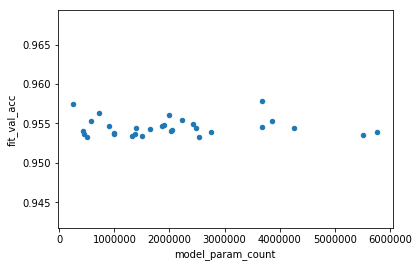

In [64]:
results.sort_values("fit_val_acc",ascending=False).head(30).plot(x='model_param_count',y='fit_val_acc', kind='scatter')

In [65]:
results.sort_values('fit_dt_test_end',ascending=False).head().T

,2146,2291,1840,3017,72
architecture,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen,video_lrcnn_frozen
batch_size,32,32,32,32,32
convolution_kernel_size,3,3,3,3,3
data_total_rows_test,3130,3130,3130,3130,3130
data_total_rows_train,60399,60399,60399,60399,60399
data_total_rows_valid,6398,6398,6398,6398,6398
dropout,0.2,0.2,0.2,0.2,0.2
fit_best_round,3,3,3,2,2
fit_dt_test_duration_seconds,25,24,23,24,22
fit_dt_test_end,2019-01-24 22:05:41,2019-01-24 21:49:55,2019-01-24 21:49:40,2019-01-24 21:19:22,2019-01-24 21:06:44


# re-allocate experiments to workers

In [ ]:
# remove experiments already done
experiments = remove_completed_experiments(experiments)

## re-assign workers on the experiments that are not complete

In [ ]:
# reassign outstanding experiments to workers
experiments = reassign_workers(experiments)

In [ ]:
##################################
### output experiment batch to CSV
##################################
print(experiment_batch_name)
experiments.to_csv(pwd + "experiments/" + experiment_batch_name + '.csv', index=False)

# Debug experiment worker

In [8]:
from deepvideoclassification.architectures import Architecture

In [9]:
WORKER_ID = 0
GPU_ID = 7
experiment_batch_name = 'experiment_batch_1'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(WORKER_ID)

In [10]:
# setup logging
# separate log file for each worker
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s, [%(levelname)-8s] [%(filename)s:%(lineno)d] %(message)s',
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(pwd, "logs_" + str(WORKER_ID))),
        logging.StreamHandler()
    ])
# init logger - will pass this to our architecture
logger = logging.getLogger()

logger.info("Start worker {} (GPU={}) processing {}".format(WORKER_ID, GPU_ID, experiment_batch_name))

2019-01-23 12:45:52,601 [MainThread  ] [INFO ]  Start worker 0 (GPU=7) processing experiment_batch_1
2019-01-23 12:45:52,601 [MainThread  ] [INFO ]  Start worker 0 (GPU=7) processing experiment_batch_1


In [11]:
# load list of experiments
experiments = pd.read_csv(pwd + "experiments/" + experiment_batch_name + '.csv')

In [12]:
experiments[experiments['model_id'].isin([2495, 2463])]

,architecture,dropout,layer_1_size,layer_2_size,layer_3_size,pooling,pretrained_model_name,sequence_length,sequence_model,sequence_model_layers,model_id,WORKER
1317,video_LRCNN_frozen,0.2,256,512,0,max,inception_resnet_v2,5,Convolution1D,2.0,2463,0
1349,video_LRCNN_frozen,0.2,256,256,0,max,inception_resnet_v2,5,Convolution1D,2.0,2495,0


,architecture,dropout,layer_1_size,layer_2_size,layer_3_size,pooling,pretrained_model_name,sequence_length,sequence_model,sequence_model_layers,model_id,WORKER
1317,video_LRCNN_frozen,0.2,256,512,0,max,inception_resnet_v2,5,Convolution1D,2.0,2463,0
1349,video_LRCNN_frozen,0.2,256,256,0,max,inception_resnet_v2,5,Convolution1D,2.0,2495,0


In [13]:
# for row in experiments.values:
debug_model_id = 5243

row = list(experiments[experiments['model_id'] == debug_model_id].values[0])

# get experiment params from dataframe row
experiment = dict(zip(experiments.columns, row))

In [14]:
experiment

{'WORKER': 6,
 'architecture': 'video_LRCNN_frozen',
 'dropout': 0.2,
 'layer_1_size': 128,
 'layer_2_size': 0,
 'layer_3_size': 0,
 'model_id': 5243,
 'pooling': 'max',
 'pretrained_model_name': 'resnet50',
 'sequence_length': 10,
 'sequence_model': 'SimpleRNN',
 'sequence_model_layers': 2.0}

{'WORKER': 6,
 'architecture': 'video_LRCNN_frozen',
 'dropout': 0.2,
 'layer_1_size': 128,
 'layer_2_size': 0,
 'layer_3_size': 0,
 'model_id': 5243,
 'pooling': 'max',
 'pretrained_model_name': 'resnet50',
 'sequence_length': 10,
 'sequence_model': 'SimpleRNN',
 'sequence_model_layers': 2.0}

In [15]:
experiments[experiments['model_id'] == debug_model_id].T

,3049
architecture,video_LRCNN_frozen
dropout,0.2
layer_1_size,128
layer_2_size,0
layer_3_size,0
pooling,max
pretrained_model_name,resnet50
sequence_length,10
sequence_model,SimpleRNN
sequence_model_layers,2


,3049
architecture,video_LRCNN_frozen
dropout,0.2
layer_1_size,128
layer_2_size,0
layer_3_size,0
pooling,max
pretrained_model_name,resnet50
sequence_length,10
sequence_model,SimpleRNN
sequence_model_layers,2


In [16]:
print(str(experiment["model_id"]) + "   " + "X"*60)
logging.info("Begin experiment for model_id={} on GPU:{} ".format(experiment['model_id'], os.environ["CUDA_VISIBLE_DEVICES"]))
print(experiment)

architecture = Architecture(model_id = experiment['model_id'], 
                            architecture = experiment['architecture'], 
                            sequence_length = experiment['sequence_length'], 
                            pretrained_model_name = experiment['pretrained_model_name'],
                            pooling = experiment['pooling'],
                            sequence_model = experiment['sequence_model'],
                            sequence_model_layers = experiment['sequence_model_layers'],
                            layer_1_size = experiment['layer_1_size'],
                            layer_2_size = experiment['layer_2_size'],
                            layer_3_size = experiment['layer_3_size'],
                            dropout = experiment['dropout'],
                            verbose=True)

2019-01-23 12:45:54,879 [MainThread  ] [INFO ]  Begin experiment for model_id=5243 on GPU:0 
2019-01-23 12:45:54,881 [MainThread  ] [INFO ]  Loading data
2019-01-23 12:45:54,879 [MainThread  ] [INFO ]  Begin experiment for model_id=5243 on GPU:0 
2019-01-23 12:45:54,881 [MainThread  ] [INFO ]  Loading data


5243   XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
{'pretrained_model_name': 'resnet50', 'sequence_model_layers': 2.0, 'layer_2_size': 0, 'WORKER': 6, 'sequence_model': 'SimpleRNN', 'sequence_length': 10, 'dropout': 0.2, 'model_id': 5243, 'architecture': 'video_LRCNN_frozen', 'layer_1_size': 128, 'pooling': 'max', 'layer_3_size': 0}
5243   XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
{'pretrained_model_name': 'resnet50', 'sequence_model_layers': 2.0, 'layer_2_size': 0, 'WORKER': 6, 'sequence_model': 'SimpleRNN', 'sequence_length': 10, 'dropout': 0.2, 'model_id': 5243, 'architecture': 'video_LRCNN_frozen', 'layer_1_size': 128, 'pooling': 'max', 'layer_3_size': 0}


2019-01-23 12:45:55,849 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/resnet50/max/
2019-01-23 12:45:55,850 [MainThread  ] [INFO ]  Loading features sequence data into memory [may take a few minutes]
2019-01-23 12:45:55,849 [MainThread  ] [INFO ]  Features already cached: /mnt/seals/cache/features/resnet50/max/
2019-01-23 12:45:55,850 [MainThread  ] [INFO ]  Loading features sequence data into memory [may take a few minutes]


Done initializing data with #samples: train=60399, valid=6398, test=3130
Done initializing data with #samples: train=60399, valid=6398, test=3130


In [17]:
architecture.train_model(epochs=1)

Train on 60399 samples, validate on 6398 samples
Epoch 1/1
Train on 60399 samples, validate on 6398 samples
Epoch 1/1
60399/60399 [==============================] - 48s 791us/step - loss: 0.1756 - acc: 0.9278 - val_loss: 0.1952 - val_acc: 0.9123

Epoch 00001: val_acc improved from -inf to 0.91234, saving model to /mnt/seals/models/5243/model_round_1.h5
H1 {'acc': [0.92784177456852], 'val_acc': [0.9123386935578096], 'val_loss': [0.195202600037392], 'loss': [0.17556339674761648]}
stopped_epoch1 0
1
0.9123386935578096

Epoch 00001: val_acc improved from -inf to 0.91234, saving model to /mnt/seals/models/5243/model_round_1.h5
H1 {'acc': [0.92784177456852], 'val_acc': [0.9123386935578096], 'val_loss': [0.195202600037392], 'loss': [0.17556339674761648]}
stopped_epoch1 0
1
0.9123386935578096
Train on 60399 samples, validate on 6398 samples
Epoch 1/1
Train on 60399 samples, validate on 6398 samples
Epoch 1/1
60399/60399 [==============================] - 33s 549us/step - loss: 0.1475 - acc: 0.

2019-01-23 12:48:06,960 [MainThread  ] [INFO ]  {
    "architecture": "video_lrcnn_frozen",
    "batch_size": 32,
    "convolution_kernel_size": 3,
    "data_total_rows_test": 3130,
    "data_total_rows_train": 60399,
    "data_total_rows_valid": 6398,
    "dropout": 0.2,
    "fit_best_round": 3,
    "fit_dt_test_duration_seconds": "0",
    "fit_dt_test_end": "2019-01-23 12:48:05",
    "fit_dt_test_start": "2019-01-23 12:48:04",
    "fit_dt_train_duration_seconds": "118",
    "fit_dt_train_end": "2019-01-23 12:48:04",
    "fit_dt_train_start": "2019-01-23 12:46:05",
    "fit_num_epochs": 3,
    "fit_stopped_epoch1": 0,
    "fit_stopped_epoch2": 0,
    "fit_stopped_epoch3": 0,
    "fit_test_acc": 0.5990415335463259,
    "fit_train_acc": 0.9433718327210892,
    "fit_train_loss": 0.13948042428104288,
    "fit_val_acc": 0.9131871765760676,
    "fit_val_loss": 0.18654302512064097,
    "frame_size": [
        224,
        224
    ],
    "layer_1_size": 128,
    "layer_2_size": 0,
    "layer_

{'model_param_count': 279559, 'data_total_rows_valid': 6398, 'fit_dt_test_start': '2019-01-23 12:48:04', 'layer_2_size': 0, 'fit_train_acc': 0.9433718327210892, 'frame_size': (224, 224), 'fit_stopped_epoch2': 0, 'dropout': 0.2, 'model_id': 5243, 'path_model': '/mnt/seals/models/5243/', 'layer_1_size': 128, 'fit_stopped_epoch1': 0, 'fit_best_round': 3, 'sequence_model_layers': 2.0, 'fit_num_epochs': 3, 'fit_stopped_epoch3': 0, 'verbose': True, 'fit_dt_test_end': '2019-01-23 12:48:05', 'pretrained_model_name': 'resnet50', 'fit_dt_test_duration_seconds': '0', 'sequence_model': 'SimpleRNN', 'batch_size': 32, 'data_total_rows_train': 60399, 'architecture': 'video_lrcnn_frozen', 'data_total_rows_test': 3130, 'num_features': 2048, 'fit_dt_train_end': '2019-01-23 12:48:04', 'fit_val_acc': 0.9131871765760676, 'fit_test_acc': 0.5990415335463259, 'sequence_length': 10, 'pooling': 'max', 'fit_dt_train_duration_seconds': '118', 'fit_dt_train_start': '2019-01-23 12:46:05', 'layer_3_size': 0, 'model_

2019-01-23 12:48:06,960 [MainThread  ] [INFO ]  {
    "architecture": "video_lrcnn_frozen",
    "batch_size": 32,
    "convolution_kernel_size": 3,
    "data_total_rows_test": 3130,
    "data_total_rows_train": 60399,
    "data_total_rows_valid": 6398,
    "dropout": 0.2,
    "fit_best_round": 3,
    "fit_dt_test_duration_seconds": "0",
    "fit_dt_test_end": "2019-01-23 12:48:05",
    "fit_dt_test_start": "2019-01-23 12:48:04",
    "fit_dt_train_duration_seconds": "118",
    "fit_dt_train_end": "2019-01-23 12:48:04",
    "fit_dt_train_start": "2019-01-23 12:46:05",
    "fit_num_epochs": 3,
    "fit_stopped_epoch1": 0,
    "fit_stopped_epoch2": 0,
    "fit_stopped_epoch3": 0,
    "fit_test_acc": 0.5990415335463259,
    "fit_train_acc": 0.9433718327210892,
    "fit_train_loss": 0.13948042428104288,
    "fit_val_acc": 0.9131871765760676,
    "fit_val_loss": 0.18654302512064097,
    "frame_size": [
        224,
        224
    ],
    "layer_1_size": 128,
    "layer_2_size": 0,
    "layer_

{'model_param_count': 279559, 'data_total_rows_valid': 6398, 'fit_dt_test_start': '2019-01-23 12:48:04', 'layer_2_size': 0, 'fit_train_acc': 0.9433718327210892, 'frame_size': (224, 224), 'fit_stopped_epoch2': 0, 'dropout': 0.2, 'model_id': 5243, 'path_model': '/mnt/seals/models/5243/', 'layer_1_size': 128, 'fit_stopped_epoch1': 0, 'fit_best_round': 3, 'sequence_model_layers': 2.0, 'fit_num_epochs': 3, 'fit_stopped_epoch3': 0, 'verbose': True, 'fit_dt_test_end': '2019-01-23 12:48:05', 'pretrained_model_name': 'resnet50', 'fit_dt_test_duration_seconds': '0', 'sequence_model': 'SimpleRNN', 'batch_size': 32, 'data_total_rows_train': 60399, 'architecture': 'video_lrcnn_frozen', 'data_total_rows_test': 3130, 'num_features': 2048, 'fit_dt_train_end': '2019-01-23 12:48:04', 'fit_val_acc': 0.9131871765760676, 'fit_test_acc': 0.5990415335463259, 'sequence_length': 10, 'pooling': 'max', 'fit_dt_train_duration_seconds': '118', 'fit_dt_train_start': '2019-01-23 12:46:05', 'layer_3_size': 0, 'model_

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

XX
upload error


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>